## Streaming data visualization

<IPython.core.display.Javascript object>


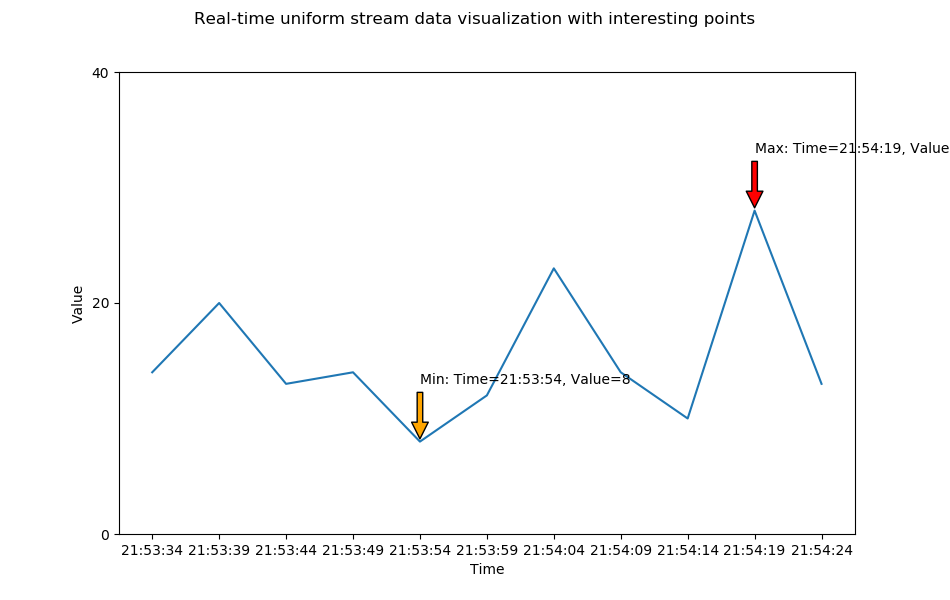

Waiting for messages


In [1]:
#C3 a i

# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'visual'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=50000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,20,40])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = json.loads(data)
            x.append(data['created_time']) 
            y.append(data['air_temperature_celcius'])

            # we start plotting only when we have 2 data points
            if len(y) > 2:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,20,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                # when there are more then 10 points, remove the oldest one
                if len(y) > 10:
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## Static   data   visualization 

In [2]:
#c 3b i
import pymongo 
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep

In [3]:
# connect on the default host and port
client = pymongo.MongoClient() 

# Getting a Database 
db = client.fit5148_db
hotspot_streaming = db.hotspot

In [4]:
# loda data
mongo_list = []
temp = hotspot_streaming.find({}).sort('created_time')
min_time = temp[0]['created_time']
for i in temp:
    mongo_list.append(i)

In [5]:
# groupby
df = pd.DataFrame.from_dict(mongo_list)
times = pd.to_datetime(df.created_time)
df_agg = df.groupby([times.dt.hour, times.dt.minute]).count()[
    ['surface_temperature_celcius']]
df_agg.index.names = ['hour', 'min']
df_agg.reset_index(inplace=True)
df_agg['time'] = df_agg['hour'].astype(str) + ':' + df_agg['min'].astype(str)

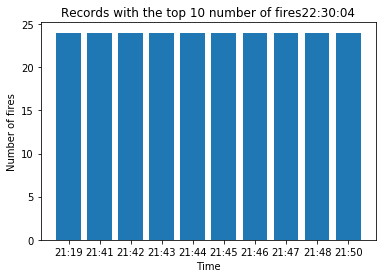

In [6]:
'''
plot
assumption: we don't need to check the plot many times
if we need to keep ploting it every few mins, use while True and sleep()
'''
if len(df_agg) <= 10:
    plt.title('top 10 number of fires ' +
              'updated:' + str(dt.datetime.now().strftime("%X")))
    plt.bar(df_agg['time'], df_agg['surface_temperature_celcius'])
    plt.xlabel('Time')
    plt.ylabel('Number of fires')
    plt.show()
else:
    df_agg.sort_values(by=['surface_temperature_celcius'],
                       ascending=False, inplace=True)
    df_agg = df_agg.iloc[:10]
    df_agg.sort_index(inplace=True)
    plt.title('Records with the top 10 number of fires' +
              str(dt.datetime.now().strftime("%X")))
    plt.bar(df_agg['time'], df_agg['surface_temperature_celcius'])
    plt.xlabel('Time')
    plt.ylabel('Number of fires')
    plt.show()

## Map

In [19]:
#c 3b ii
import gmplot
import webbrowser  # gmplot contains a simple wrapper around
# Google’s geocoding service enabling map initilization to the location of your choice.
import pymongo
from pprint import pprint
# the initial location of the map
gmap = gmplot.GoogleMapPlotter(-38.01, 133.23, zoom=7)

# connect to mongodb
client = pymongo.MongoClient()
db = client.fit5148_db
climate = db.climate

'''
retrieve data from mongodb 
assume that we only use streaming data(climate and hotspot) from previous tasks
'''
climate_list = []

tmp = list(climate.find({'hotspots':{'$exists':'true'}}))
fake = climate.find({})
fakeClimates = fake[0]
if len(tmp) == 0:
    print('yes')
    item = fakeClimates
    gmap.marker(
                    item['latitude'],
                    item['longitude'],
                    title= 
                        "relative humidity: " + str(item['relative_humidity']) +
                        "air temperature: " + str(item['air_temperature_celcius'])
                )
else:   
    for result in tmp:
        for item in result.get('hotspots'):
            gmap.marker(
                    result['latitude'],
                    result['longitude'],
                    title="confidence: "+str(item['confidence']) +
                    '  '+"surface temperature : "+str(item['surface_temperature_celcius']) +
                    '  '+"relative humidity: " + str(result['relative_humidity']) +
                    '  '+"air temperature: " + str(result['air_temperature_celcius'])
                )
gmap.draw("availableParkings.html")
webbrowser.open_new("availableParkings.html")
client.close()

In [15]:
client = pymongo.MongoClient()
db = client.fit5148_db
climate = db.climate

'''
retrieve data from mongodb 
assume that we only use streaming data(climate and hotspot) from previous tasks
'''
climate_list = []
temp = list(climate.find({'hotspots':{'$exists':'true'}}))

for result in temp:
    print(result.get('hotspots'))


[{'confidence': 54.0, 'surface_temperature_celcius': 31.0, 'sender_id': 'producer2', 'created_time': '21:42:41', '_id': ObjectId('5ce7d8baba8015285d17aaa5')}]
